In [17]:
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from PIL import Image

In [25]:
csv_dir = 'loss_study/5'
names = [
    't',
    'nonback_ratio_cond',
    'nonback_ratio_target',
    'polar_cond',
    'polar_target',
    'azimuth_cond',
    'azimuth_target',
    'prompt_mask_val',
    'input_mask_val',
    'obj_name',
    'index_cond',
    'index_target',
    'loss']
df = None
for i in range(1):
    table = pd.read_csv(os.path.join(csv_dir, f'log_losses_{i}.csv'), names=names)
    if df is None:
        df = table
    else:
        df = pd.concat([df, table], axis=0)
df['prompt_mask_val'] = 1 - df['prompt_mask_val']

In [19]:
df['azimuth_abs_shift'] = 180 / np.pi * np.minimum(
    abs(df['azimuth_cond'] - df['azimuth_target']),
    abs(abs(df['azimuth_cond'] - df['azimuth_target']) - np.pi * 2))

In [20]:
df['polar_abs_shift'] = 180 / np.pi * abs(df['polar_cond'] - df['polar_target'])

In [21]:
df['back_ratio_cond_target'] = df['nonback_ratio_cond'] / df['nonback_ratio_target']

In [44]:
df['polar_cond_degree'] = df['polar_cond'] / np.pi * 180
df['polar_target_degree'] = df['polar_target'] / np.pi * 180
df['azimuth_cond_degree'] = df['azimuth_cond'] / np.pi * 180
df['azimuth_target_degree'] = df['azimuth_target'] / np.pi * 180

In [3]:
len(df)

96800

In [4]:
df.head()

,t,nonback_ratio_cond,nonback_ratio_target,polar_cond,polar_target,azimuth_cond,azimuth_target,prompt_mask_val,input_mask_val,obj_name,loss
0,442,0.484856,0.411022,2.201899,1.117547,4.370132,2.432682,1,0,a94bc3fc1eaf426c9bf62a27614fa255,0.063084
1,275,0.020805,0.016037,2.043820,2.332772,-1.459047,3.440950,0,1,d3d12de5357649ecad9e08997a4ddf85,0.004125
2,22,0.107002,0.250935,1.570796,2.013911,4.712389,-0.905459,1,1,0abed0d05bfa4fac91c87537643f9aca,0.157745
3,137,0.638973,0.221375,1.674673,0.846626,-0.275820,1.189878,1,0,9d590dbe62684a59925217a652df1ec6,0.081771
4,375,0.267330,0.137955,1.089152,1.589643,-0.369090,4.048220,1,1,4f14a8de87244ee6bb1a8cc5c7708b7c,0.027167


In [13]:
print("No clip, no latent cond")
df.loc[(df['prompt_mask_val'] == 0) & (df['input_mask_val'] == 0), 'loss'].mean()

No clip, no latent cond


0.04272418985027267

In [54]:
print("No clip, only latent cond")
df.loc[(df['prompt_mask_val'] == 0) & (df['input_mask_val'] == 1), 'loss'].mean()

No clip, only latent cond


0.03764307155748821

In [15]:
print("Only clip, no latent cond")
df.loc[(df['prompt_mask_val'] == 1) & (df['input_mask_val'] == 0), 'loss'].mean()

Only clip, no latent cond


0.04228023926009701

In [16]:
print("clip, latent cond")
df.loc[(df['prompt_mask_val'] == 1) & (df['input_mask_val'] == 1), 'loss'].mean()

clip, latent cond


0.03799369378638651

In [53]:
sum((df['prompt_mask_val'] == 0))

9816

In [13]:
sum(df['loss'] < 0.017)

47552

In [26]:
df['loss'].mean()

0.038134047616638425

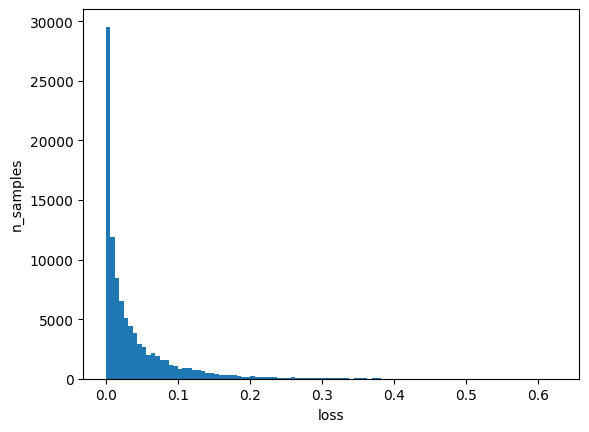

In [32]:
plt.hist(df.loss, bins=100) #np.logspace(0, 0.1, 100) - 1)
plt.xlabel("loss")
plt.ylabel("n_samples")
# plt.gca().set_xscale("log")
plt.show()

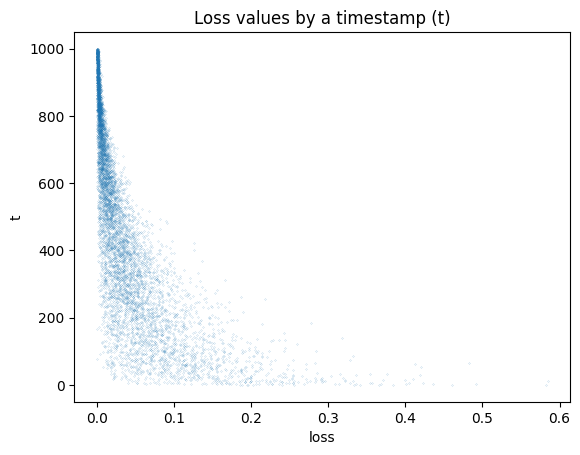

In [28]:
df.plot.scatter(x='loss', y='t', s=0.01,
                title="Loss values by a timestamp (t)");

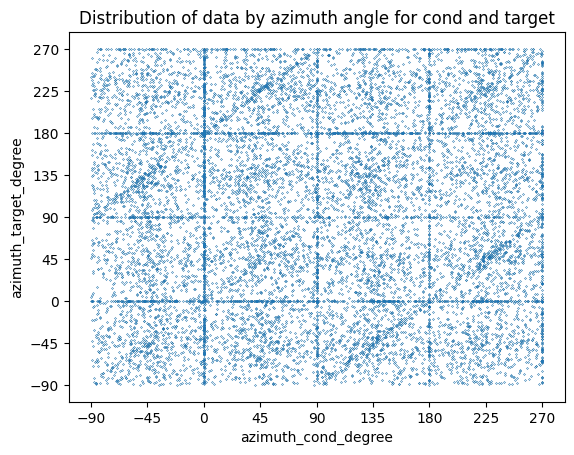

In [51]:
df.plot.scatter(x='azimuth_cond_degree',
                y='azimuth_target_degree', s=0.005,
                # xticks=[0, 30, 60, 90, 120, 150, 180],
                # yticks=[0, 30, 60, 90, 120, 150, 180],
                xticks=[-90, -45, 0, 45, 90, 135, 180, 225, 270],
                yticks=[-90, -45, 0, 45, 90, 135, 180, 225, 270],
                title="Distribution of data by azimuth angle for cond and target");

<Axes: title={'center': 'Mean loss for different cond/target azimuth angles'}, xlabel='azimuth_cond_degree', ylabel='azimuth_target_degree'>

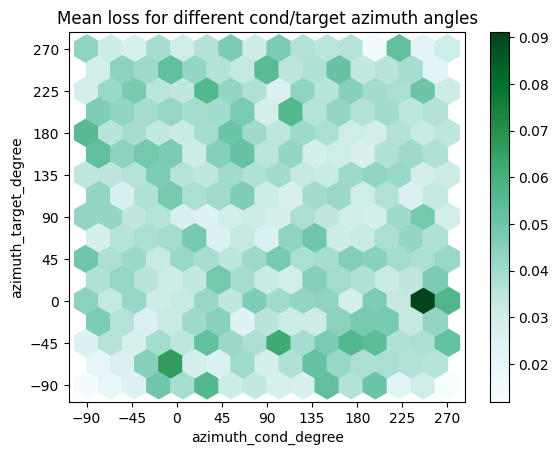

In [52]:
df.plot.hexbin(x='azimuth_cond_degree',
               y='azimuth_target_degree',
               C='loss',
               reduce_C_function=np.mean,
               gridsize=15,
               title="Mean loss for different cond/target azimuth angles",
               # xticks=[0, 30, 60, 90, 120, 150, 180],
               # yticks=[0, 30, 60, 90, 120, 150, 180],
               xticks=[-90, -45, 0, 45, 90, 135, 180, 225, 270],
               yticks=[-90, -45, 0, 45, 90, 135, 180, 225, 270],
            #    title="Distribution of data by absolute angle shift between cond and target");
)

In [27]:
bins = np.linspace(0,180,18)
groups = df.groupby(pd.cut(df.azimuth_abs_shift, bins));

In [28]:
plot_centers = (bins [:-1] + bins [1:])/2
plot_mean_values = groups.loss.mean();
plot_std_values = groups.loss.std();
plot_size_values = groups.loss.size();

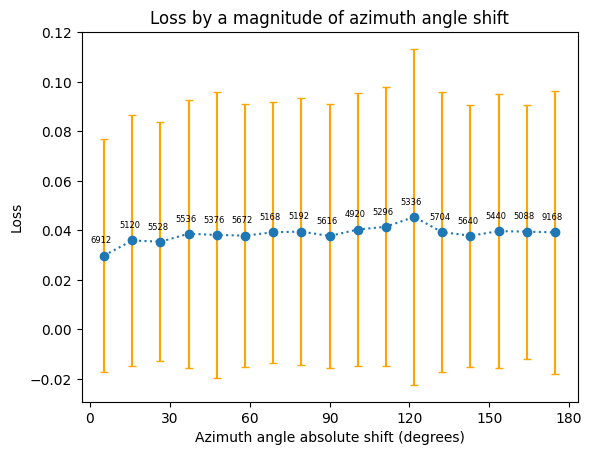

In [29]:
plt.errorbar(plot_centers, plot_mean_values, plot_std_values,
             linestyle='dotted', fmt='o', ecolor='orange', capsize=3)
for x, y, s in zip(plot_centers, plot_mean_values, plot_size_values):
    plt.text(x-5, y+0.005, s, fontsize=(6))
plt.xlabel("Azimuth angle absolute shift (degrees)")
plt.ylabel("Loss")
plt.title("Loss by a magnitude of azimuth angle shift")
plt.xticks([0, 30, 60, 90, 120, 150, 180]);

In [76]:
df.loc[(df['t'] > 500)].sort_values('loss', ascending=False).head(10)

,t,nonback_ratio_cond,nonback_ratio_target,polar_cond,polar_target,azimuth_cond,azimuth_target,prompt_mask_val,input_mask_val,obj_name,loss,azimuth_abs_shift,polar_abs_shift,back_ratio_cond_target,polar_cond_degree,polar_target_degree,azimuth_cond_degree,azimuth_target_degree
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9829,511,0.225941,0.317287,1.254025,0.900180,3.774906,1.156581,1,1,251325dc75544d91ad55286a75392aef,0.070311,150.018947,20.273846,0.712101,71.850357,51.576511,216.286178,66.267231
9662,509,0.665764,0.664333,1.968365,1.408462,4.192867,2.340640,1,1,7a6cab357bfc4df5964a4d2286a70516,0.066582,106.124775,32.080034,1.002153,112.778988,80.698954,240.233582,134.108807
9662,509,0.665764,0.664333,1.968365,1.408462,4.192867,2.340640,1,1,7a6cab357bfc4df5964a4d2286a70516,0.066582,106.124775,32.080034,1.002153,112.778988,80.698954,240.233582,134.108807


In [77]:
import tarfile 
tarname = "251325dc75544d91ad55286a75392aef"
data_dir = "/scratch/objaverse_renders"

tar = tarfile.open(os.path.join(data_dir, f'{tarname}.tar'))

In [78]:
img_num = 0
image = tar.extractfile(f'{tarname}/rgba/rgba_{img_num:04d}.png').read()
image = Image.open(io.BytesIO(image)).convert('RGBA')

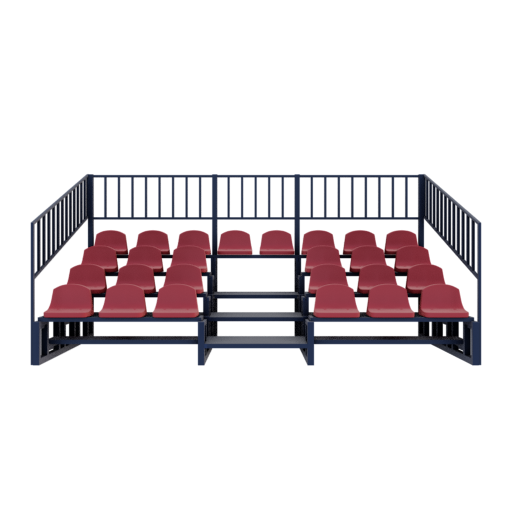

In [79]:
image

In [112]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [105]:
X_tr, X_eval = train_test_split(df.loc[df.t > 500], test_size=0.1)

In [106]:
y_tr = X_tr.loss
X_tr.drop(columns=['loss', 'obj_name'], inplace=True)

In [111]:
y_test = X_eval.loss
X_eval.drop(columns=['loss', 'obj_name'], inplace=True)

In [107]:
train_dataset = Pool(X_tr, y_tr, feature_names=list(X_tr.columns))

In [108]:
model_params = {
    'iterations': 100, 
    # 'loss_function': 'Logloss',
    # 'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
    'learning_rate': 1,
    'depth': 5
}

model = CatBoostRegressor(**model_params)
model.fit(train_dataset, verbose=True, plot=False)

0:	learn: 0.0054403	total: 4.09ms	remaining: 405ms
1:	learn: 0.0051585	total: 7.68ms	remaining: 376ms
2:	learn: 0.0049538	total: 10.3ms	remaining: 334ms
3:	learn: 0.0048167	total: 13ms	remaining: 312ms
4:	learn: 0.0047022	total: 15.6ms	remaining: 296ms
5:	learn: 0.0046524	total: 18.2ms	remaining: 285ms
6:	learn: 0.0045890	total: 21.1ms	remaining: 281ms
7:	learn: 0.0045482	total: 23.7ms	remaining: 273ms
8:	learn: 0.0044942	total: 26.3ms	remaining: 266ms
9:	learn: 0.0044457	total: 28.9ms	remaining: 260ms
10:	learn: 0.0044004	total: 31.4ms	remaining: 254ms
11:	learn: 0.0043427	total: 34.1ms	remaining: 250ms
12:	learn: 0.0042951	total: 36.6ms	remaining: 245ms
13:	learn: 0.0042388	total: 39.3ms	remaining: 241ms
14:	learn: 0.0042016	total: 42ms	remaining: 238ms
15:	learn: 0.0041749	total: 44.6ms	remaining: 234ms
16:	learn: 0.0041381	total: 47ms	remaining: 229ms
17:	learn: 0.0040960	total: 49.9ms	remaining: 227ms
18:	learn: 0.0040709	total: 52.6ms	remaining: 224ms
19:	learn: 0.0040213	total: 

In [109]:
model.feature_importances_

array([41.48691271,  3.13281137, 20.07814709,  3.11503414,  3.30735715,
        2.43339938,  3.03866583,  0.18061229,  1.97132139,  6.38213557,
        5.85071437,  4.20123132,  0.73798735,  2.21299016,  0.50903649,
        1.36164338])

Text(0.5, 1.0, 'Feature Importance')

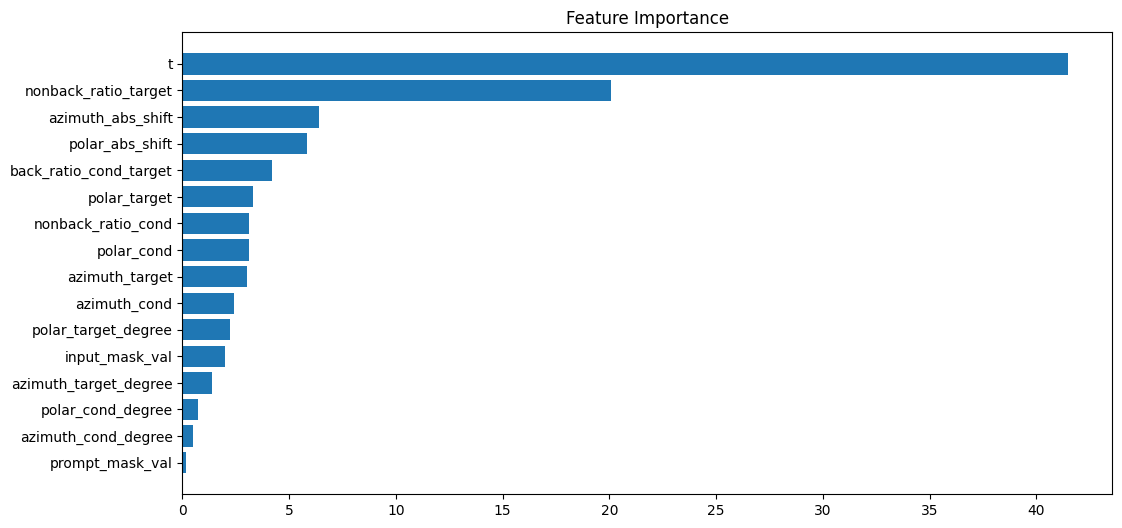

In [110]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_tr.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
import torch
state = torch.load('/fsx/proj-mod3d/dmitry/zero123logs/2023-07-11T18-28-40_sd-ext-objaverse-latents/checkpoints/trainstep_checkpoints/epoch=001707-step=000204999.ckpt')

In [7]:
cc_projection = state["state_dict"]['cc_projection.weight']

In [15]:
cc_normed = cc_projection.abs().clamp(0, 1) #/ cc_projection.max()

In [12]:
from torchvision import transforms

In [14]:
cc_normed.median()

tensor(0.0075, device='cuda:0')

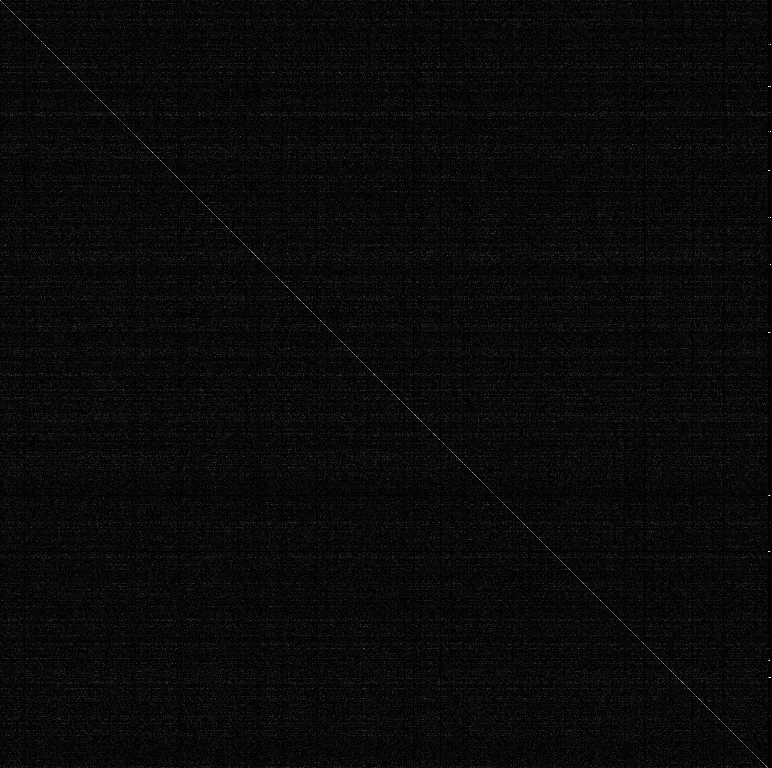

In [16]:
transforms.ToPILImage()(cc_normed)

In [5]:
sorted(list(state["state_dict"].keys()))[:100]

['alphas_cumprod',
 'alphas_cumprod_prev',
 'betas',
 'cc_projection.bias',
 'cc_projection.weight',
 'log_one_minus_alphas_cumprod',
 'model.diffusion_model.input_blocks.0.0.bias',
 'model.diffusion_model.input_blocks.0.0.weight',
 'model.diffusion_model.input_blocks.1.0.emb_layers.1.bias',
 'model.diffusion_model.input_blocks.1.0.emb_layers.1.weight',
 'model.diffusion_model.input_blocks.1.0.in_layers.0.bias',
 'model.diffusion_model.input_blocks.1.0.in_layers.0.weight',
 'model.diffusion_model.input_blocks.1.0.in_layers.2.bias',
 'model.diffusion_model.input_blocks.1.0.in_layers.2.weight',
 'model.diffusion_model.input_blocks.1.0.out_layers.0.bias',
 'model.diffusion_model.input_blocks.1.0.out_layers.0.weight',
 'model.diffusion_model.input_blocks.1.0.out_layers.3.bias',
 'model.diffusion_model.input_blocks.1.0.out_layers.3.weight',
 'model.diffusion_model.input_blocks.1.1.norm.bias',
 'model.diffusion_model.input_blocks.1.1.norm.weight',
 'model.diffusion_model.input_blocks.1.1.pro